I used LASSO regression on a real EEG dataset to determine the brain region that is active under an auditory stimulus.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## Load the Data

Data source: https://martinos.org/mne/stable/index.html


In [ ]:
fn_src ='https://drive.google.com/uc?export=download&id=1RzQpKONOcXSMxH2ZzOI4iVMiTgD6ttSl'
fn_dst ='eeg_dat.p'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    print('Fetching file %s [53MB].  This may take a minute..' % fn_dst)
    urllib.request.urlretrieve(fn_src, fn_dst)
    print('File %s downloaded' % fn_dst)

Fetching file eeg_dat.p [53MB].  This may take a minute..
File eeg_dat.p downloaded


In [ ]:
import pickle
fn = 'eeg_dat.p'
with open(fn, 'rb') as fp:
    [X,Y] = pickle.load(fp)

Key variables:
* `nt`    = number of time steps that we measure data
* `nchan` = number of channels (i.e. electrodes) measured in each time step
* `ncur`  = number of currents in the brain that we want to estimate.  

Each current comes from one brain region (called a *voxel*) in either the `x`, `y` or `z` direction.  So,

    nvoxels = ncur / 3
    
The components of the `X` and `Y` matrices :
*  `Y[i,k]` = electric field measurement on channel `i` at time `k`
*  `X[i,j]` = sensitivity of channel `i` to current `j`.



In [ ]:
nt = Y.shape[1]
ncur = X.shape[1]
nchan = X.shape[0]
nvoxels = ncur / 3

print("Nt : ", nt)
print("Ncur : ", ncur)
print("Nchan : ", nchan)
print("nvoxels : ", nvoxels)

Nt :  85
Ncur :  22494
Nchan :  305
nvoxels :  7498.0


## Ridge Regression

    number of measurements  << number of unknowns
    
Hence regularization required 

In [ ]:
Xtr,Xts,Ytr,Yts = train_test_split(X, Y, test_size = 0.33) 

In [ ]:
reg = Ridge(alpha=1)
reg.fit(Xtr, Ytr)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [ ]:
Ytr_pred = reg.predict(Xtr)
rsq_tr = r2_score(Ytr, Ytr_pred)

Yts_pred = reg.predict(Xts)
rsq_ts = r2_score(Yts, Yts_pred)

print("Normalized test R^2 = %f" % rsq_tr)
print("Normalized test R^2 = %f" % rsq_ts)

Normalized test R^2 = 0.575603
Normalized test R^2 = 0.123072


`R^2` value is large for the training data, it is very low for the test data.  This suggest that even with regularization, the model is over-fitting the data.
We try getting better `R^2` score using different values of `alpha`. 

In [ ]:
alphas = np.logspace(-2,2,20)
rsq = []

for alpha in alphas:
  reg = Ridge(alpha = alpha)
  reg.fit(Xtr, Ytr)

  Yhat = reg.predict(Xts)
  rsq.append(r2_score(Yts, Yhat))

for ind in range(0, 20):
  print(ind, " Alpha: %f, RSS: %f" % (alphas[ind], rsq[ind]))

0  Alpha: 0.010000, RSS: -0.160758
1  Alpha: 0.016238, RSS: -0.077923
2  Alpha: 0.026367, RSS: -0.007689
3  Alpha: 0.042813, RSS: 0.052198
4  Alpha: 0.069519, RSS: 0.102316
5  Alpha: 0.112884, RSS: 0.140651
6  Alpha: 0.183298, RSS: 0.163606
7  Alpha: 0.297635, RSS: 0.168883
8  Alpha: 0.483293, RSS: 0.157974
9  Alpha: 0.784760, RSS: 0.136076
10  Alpha: 1.274275, RSS: 0.109713
11  Alpha: 2.069138, RSS: 0.084137
12  Alpha: 3.359818, RSS: 0.062094
13  Alpha: 5.455595, RSS: 0.044213
14  Alpha: 8.858668, RSS: 0.030114
15  Alpha: 14.384499, RSS: 0.019241
16  Alpha: 23.357215, RSS: 0.011105
17  Alpha: 37.926902, RSS: 0.005240
18  Alpha: 61.584821, RSS: 0.001172
19  Alpha: 100.000000, RSS: -0.001556


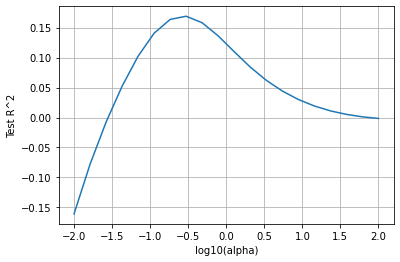

Optimal R^2 Ridge:  0.168883


In [ ]:
plt.errorbar(np.log10(alphas), rsq)
plt.xlabel('log10(alpha)')
plt.ylabel('Test R^2')
plt.grid()
plt.show()

print('Optimal R^2 Ridge:  %f' % np.max(rsq))

In [ ]:
optimal_alpha_location = np.argmax(rsq)
optimal_alpha = alphas[optimal_alpha_location]

reg = Ridge(alpha = optimal_alpha)
reg.fit(Xtr, Ytr)

W = np.matrix.transpose(reg.coef_)
Wrms = np.sqrt(np.sum(np.square((W)),axis=1))
print ("Number of non zero elements in vector Wrms, %d" % np.count_nonzero(Wrms))

Number of non zero elements in vector Wrms, 22494


## LASSO Regression

We can improve the estimate by imposing sparsity.  We can impose this constraint using LASSO regularization.

In [ ]:
reg = Lasso(alpha=1e-3, max_iter=100, tol=0.01)
reg.fit(Xtr,Ytr)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.01, warm_start=False)

In [ ]:
Ytr_pred = reg.predict(Xtr)
rsq_tr = r2_score(Ytr, Ytr_pred)

Yts_pred = reg.predict(Xts)
rsq_ts = r2_score(Yts, Yts_pred)

print("Normalized test R^2 = %f" % rsq_tr)
print("Normalized test R^2 = %f" % rsq_ts)

Normalized test R^2 = 0.144870
Normalized test R^2 = 0.111769


I used cross-validation to find the optimal `alpha`.Also for each `alpha`, the current matrix is stored so that we do not have to re-fit the model.

In [ ]:
alphas = np.logspace(-3,-4,5)
rsq = []

for alpha in alphas:
  reg = Lasso(alpha=alpha, max_iter=100, tol=0.01)
  reg.fit(Xtr,Ytr)

  Yhat = reg.predict(Xts)
  rsq.append(r2_score(Yts, Yhat))

for ind in range(0, 5):
  print(ind, " Alpha: %f, RSS: %f" % (alphas[ind], rsq[ind]))

0  Alpha: 0.001000, RSS: 0.111769
1  Alpha: 0.000562, RSS: 0.214158
2  Alpha: 0.000316, RSS: 0.266817
3  Alpha: 0.000178, RSS: 0.290217
4  Alpha: 0.000100, RSS: 0.278681


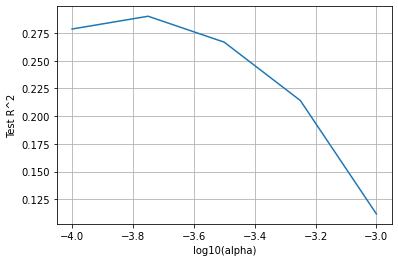

Optimal R^2 LASSO:  0.290217


In [ ]:
plt.errorbar(np.log10(alphas), rsq)
plt.xlabel('log10(alpha)')
plt.ylabel('Test R^2')
plt.grid()
plt.show()

print('Optimal R^2 LASSO:  %f' % np.max(rsq))

The current matrix `W` for the optimal `alpha` is much sparser.

In [ ]:
optimal_alpha_location = np.argmax(rsq)
optimal_alpha = alphas[optimal_alpha_location]

reg = Lasso(alpha=optimal_alpha, max_iter=100, tol=0.01)
reg.fit(Xtr, Ytr)

W = np.matrix.transpose(reg.coef_)
Wrms = np.sqrt(np.sum(np.square((W)),axis=1))
print ("Number of non zero elements in vector Wrms, %d" % np.count_nonzero(Wrms))

Number of non zero elements in vector Wrms, 527
